##### Metody obliczeniowe w nauce i technice

## Laboratorium 11 - Generatory liczb losowych

### Sprawozdanie sporządził: Marcin Zielonka

### Wstęp

Do realizacji zadań skorzystam z gotowych funkcjonalności zawartych w bibliotekach:
- `numpy` - wersja `1.18.2`
- `matplotlib` - wersja `3.2.0`
- `scipy` - wersja `1.4.1`
- `math`
- `random`

In [1]:
import numpy as np
import random
from numpy.random import Generator, PCG64
from matplotlib import pyplot as plt
import math
from scipy import special, stats

### Zadanie 1: Testowanie generatorów liczb losowych

Dla obydwu generatorów liczb losowych (Mersenne Twister oraz PCG64) oraz dla $n=10,1000,5000$ wylosuj $n$ liczb losowych pochodzących z rozkładu jednostajnego i wykonaj następujące kroki:

1. Zwizualizuj na wykresie rozkład liczb w 10 równych przedziałach.
2. Sprawdź dla ilu liczb spełniona jest nierówność $x_i<x_{i+1}$. Ile powinno ich być dla idealnego generatora?
3. Zaimplementuj jeden z testów zdefiniowanych w rozdziale drugim artykułu https://csrc.nist.gov/publications/detail/sp/800-22/rev-1a/final i wykorzystaj go do sprawdzenia wylosowanego ciągu liczb.

Czy widać różnice pomiędzy generatorami? Czy wraz z rosnącym $n$ coś się zmienia?

Na początku stworzyłem funkcję, która przyjmuje dwa parametry:
- `amount` - ilość wartości do wygenerowania
- `mode` - generator liczb losowych, która ma zostać użyty

Funkcja ta losuje $n$ liczb z przedziału $(0,1)$ pochodzących z rozkładu jednostajnego

In [6]:
def generate_random(amount, mode='mersenne'):
    result = np.zeros(amount)
    
    if mode == 'mersenne':
        result = np.array(list(map(lambda x: random.uniform(0, 1), result)))
    elif mode == 'pcg64':
        rg = Generator(PCG64())
        result = np.array(list(map(lambda x: rg.uniform(0, 1), result)))
    else:
        print('Invalid mode')
    
    return result

W kolejnym kroku napisałem funkcję pomocniczą, która na podstawie danego ciągu liczb, tworzy i wyświetla histogram, na którym pokazany jest rozkład liczb w 10 równych przedziałach:

In [7]:
def visualise_distribution(values):
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    
    axs.hist(values, bins=10)

Następnie napisałem funkcję, która określa dla ilu liczb w danym ciągu jest spełniona zależność $x_i<x_{i+1}$

In [8]:
def check_relationship_between_neighbours(values):
    sum = 0
    
    for i in range(1, len(values)):
        if values[i - 1] < values[i]:
            sum += 1
    
    return sum

Na końcu zaimplementowałem jeden z testów przedstawionych w rozdziale drugim artykułu https://csrc.nist.gov/publications/detail/sp/800-22/rev-1a/final - *Discrete Fourier Transform (Spectral) Test*

Test ten polega na tym, iż na podstawie ciągu wartości $0$ i $1$ określamy przy wykorzystaniu DFT wartość $pValue$. Jeżeli otrzymana wartość jest mniejsza od $0.01$, to testowana sekwencja jest nielosowa.

Dokładny opis wykonania testu:

1. Dany mam ciąg $0$ i $1$: $\epsilon=\epsilon_1,\epsilon_2,\epsilon_3,...,\epsilon_n$ o długości $n$
2. Tworzymy ciąg $X=x_1,x_2,x_3,...,x_n$ zgodnie ze wzorem: $x_i=2\epsilon_i-1$
3. Na ciągu X dokonujemy DFT i otrzymujemy sekwencję wartości $S$, gdzie $S=DFT(X)$
4. Obliczamy ciąg $M$ zgodnie ze wzorem: $M=|S'|$, gdzie $S'$ to sekwencja pierwszych $n/2$ elementów ciągu $S$
5. Obliczamy wartość $T$ zgodnie ze wzorem: $T=\sqrt{(\log{\frac{1}{0.05}})n}$, która jest równa $95%$ progowi wartości szczytów (*peak height treshold*). Zakładając losowość ciągu, $95%$ wartości otrzymanych w teście nie powinno przekraczać wartości $T$
6. Obliczamy wartość $N_0$ zgodnie ze wzorem: $N_0=0.95n/2$, gdzie $N_0$ jest oczekiwaną teoretyczną ilością wartości szczytów(przy założeniach losowości) mniejszych od $T$
7. Obliczamy wartość $N_1$, która jest rzeczywistą ilością wartości szczytów (w sekwencji $M$), które są mniejsze od wartości $T$
8. Obliczamy wartość $d$ zgodnie ze wzorem: $d=\frac{(N_1-N_0)}{\sqrt{n\cdot0.95\cdot0.05/4}}$
9. Obliczamy wartość $pValue$ zgodnie ze wzorem: $pValue=erfc(\frac{|d|}{\sqrt{2}})$

Aby sprawdzić losowość obu generatorów liczb losowych przy użyciu tego testu, sekwencję wartości $0$ i $1$, która jest potrzebna do testu otrzymałem w następujący sposób:

$$
\epsilon_i = \left\{ \begin{array}{ll}
0 & t_i \leqslant 0.5\\
1 & \textrm{wpp}\\
\end{array} \right.
$$

gdzie $t_i$ to wylosowana liczba z przedziału $(0,1)$ pochodzących z rozkładu jednostajnego

In [24]:
def dft_test(sample):
    n = len(sample)
    
    sample = np.array(list(map(lambda x: 0 if x <= 0.5 else 1, sample)))
    
    X = sample * 2 - 1
    S = np.fft.fft(X)

    M = np.abs(S)[:math.floor(n / 2)]
    
    T = np.sqrt(np.log(1 / 0.05) * n)
    
    N0 = 0.95 * n / 2
    N1 = len([x for x in M if x < T])
    
    d = (N1 - N0) / math.sqrt(n * 0.95 * 0.05 / 4)
    p = special.erfc(abs(d) / np.sqrt(2))
    
    return p

Na końcu napisałem funkcję pomocniczą, która dla danej długości ciągu liczb i typu generatora, generuje i wyświetla poszczególne wyniki:

In [25]:
def check_sample(amount, mode):
    sample = generate_random(amount, mode=mode)
    visualise_distribution(sample)

    related_count = check_relationship_between_neighbours(sample)
    p_value = dft_test(sample)

    print(f'related: {related_count},\tp_value: {p_value}')

Wyniki dla generatora liczb losowych *Mersenne Twister*:

- dla $n=10$:

related: 3,	p_value: 0.4681599098544281


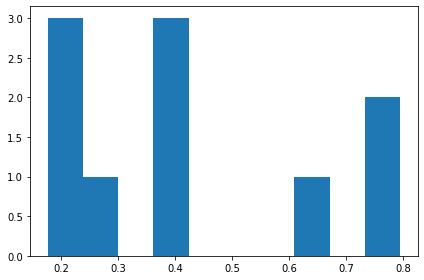

In [26]:
check_sample(10, 'mersenne')

- dla $n=1000$:

related: 487,	p_value: 0.38398816339805664


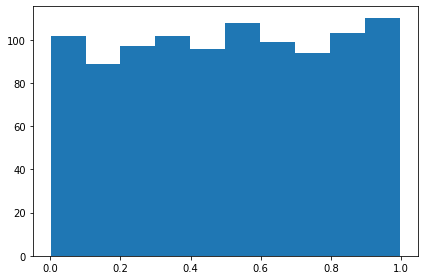

In [29]:
check_sample(1000, 'mersenne')

- dla $n=5000$:

related: 2507,	p_value: 0.6036850480049218


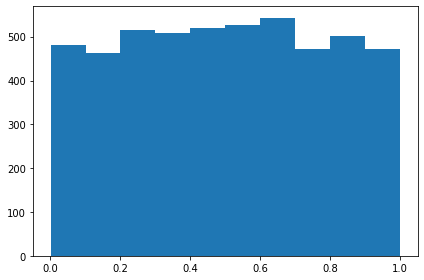

In [30]:
check_sample(5000, 'mersenne')

Wyniki dla generatora liczb losowych *PCG64*:

- dla $n=10$:

related: 4,	p_value: 0.4681599098544281


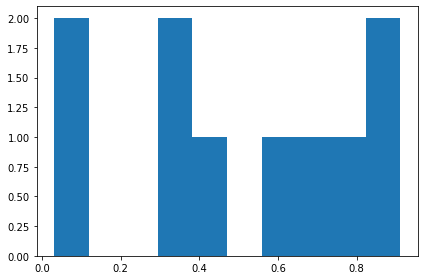

In [32]:
check_sample(10, 'pcg64')

- dla $n=1000$:

related: 475,	p_value: 0.7716705035436164


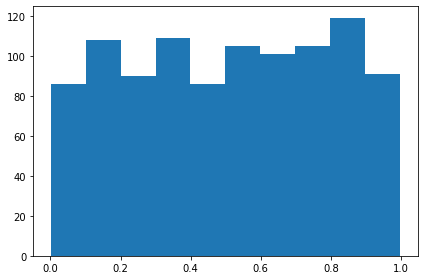

In [33]:
check_sample(1000, 'pcg64')

- dla $n=5000$:

related: 2438,	p_value: 0.8967427520264305


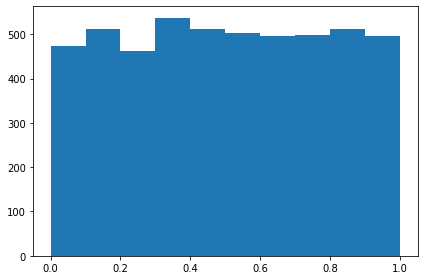

In [34]:
check_sample(5000, 'pcg64')

Dodatkowo, napisałem funkcję, która wyświetla na wykresie średnią wartość $pValue$ dla obu generatorów  w zależności od długości ciągu liczb $n$:

Parametry funkcji:
- `max` - maksymalna długość ciągu liczb
- `mode` - typ generatora liczb losowych
- `attempts_per_once` - ilość prób obliczania wartości $pValue$ dla danej długości ciągu

In [40]:
def show_dft_results(max, mode, attempts_per_once=10):
    xs = np.arange(1,max + 1,1)
    ys = []
    
    for i in xs:
        sum = 0
        for j in range(attempts_per_once):
            sum += dft_test(generate_random(i, mode=mode))
        ys.append(sum / attempts_per_once)
    
    plt.plot(xs, ys)
    plt.show()

Wyniki dla generatora liczb losowych *Mersenne Twister*:

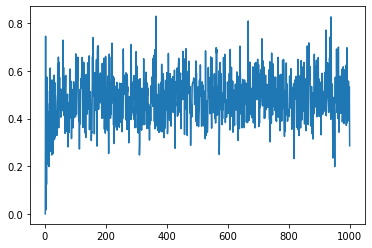

In [41]:
show_dft_results(1000, 'mersenne')

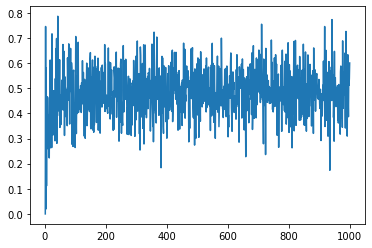

In [42]:
show_dft_results(1000, 'pcg64')

Analiza otrzymanych wyników:

Dla obu generatorów liczba wartości sąsiednich, które spełniają zależność $x_i<x_{i+1}$ przy większych wartościach $n$ jest zawsze bliska wartości $\frac{n}{2}$. Dla idealnego generatora wartość ta powinna być równa $\frac{n}{2}$ (czyli połowie wartości w ciągu), gdyż wtedy stwierdzamy, że kolejne wartości były losowane z takim samym prawdopodobieństwem.

Również dla obu generatorów, otrzymane wartości $pValue$ są dla większych długości ciągów $n$ większe od wartości $0.01$, tak więc możemy na tej podstawie stwierdzić, że ciągi wartości generowanych przez te generatory są losowe.

### Zadanie 2: Generowanie liczb z rozkładu normalnego

Zaimplementuj generator liczb losowych pochodzących z rozkładu normalnego za pomocą metody Boksa-Mullera i zaprezentuj wyniki dla n = 10, 100, 5000 wygenerowanych liczb. Funkcja powinna dodatkowo przyjmować wartość oczekiwaną oraz odchylenie standardowe jako parametry.

1. Zwizualizuj na wykresie rozkład liczb w 10 równych przedziałach. Na tym samym wykresie umieść funkcję gęstości prawdopodobieństwa rozkładu normalnego o takich samych parametrach.
2. Wykonaj test statystyczny Shapiro-Wilka, przedstaw uzyskaną p-wartość, informację czy hipoteza zerowa została przyjęta/odrzucona dla $\alpha=0.05$ i czy w związku z tym są podstawy do stwierdzenia że liczby pochodzą z rozkładu normalnego.

Na początku zaimplementowałem algorytm, który zwraca ciąg losowych liczb pochodzących z rozkładu normalnego na podstawie parametrów:
- `n` - ilość liczb
- `mi` - wartość oczekiwana
- `sigma` - odchylenie standardowe

Do tego celu wykorzystałem metodę Boksa-Mullera, która wygląda następująco:

$$Z_1=\sqrt{-2ln(U_1)}\cos(2\pi U_2)$$
$$Z_2=\sqrt{-2ln(U_1)}\sin(2\pi U_2)$$

gdzie:
- $U_1$ i $U_2$ to niezależne zmienne losowe pochodzące z rozkładu jednostajnego
- $Z_1$ i $Z_2$ to niezależne zmienne losowe pochodzące z rozkładu normalnego

Przy implementacji algorytmu, zmienne losowe $U_1$ i $U_2$ to po prostu ciąg długości $n$ losowych liczb z przedziału $(0,1)$ pochodzących z rozkładu jednostajnego.

Aby uwzględnić dodatkowe parametry, jakimi są wartości oczekiwana $\mu$ oraz odchylenie standardowe $\sigma$, przekształciłem wcześniejszy wzór do postaci:

$$Z_1=\mu + \sigma\sqrt{-2ln(U_1)}\cos(2\pi U_2)$$
$$Z_2=\mu + \sigma\sqrt{-2ln(U_1)}\sin(2\pi U_2)$$

In [45]:
def box_muller(n, mi, sigma):
    u1 = np.array(list(map(lambda x: random.uniform(0, 1), np.zeros(n))))
    u2 = np.array(list(map(lambda x: random.uniform(0, 1), np.zeros(n))))
    
    z1 = mi + sigma * np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    z2 = mi + sigma * np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
    
    return z1, z2

W kolejnym kroku napisałem funkcję pomocniczą, która na podstawie danego ciągu liczb, tworzy i wyświetla histogram, na którym pokazany jest rozkład liczb w 10 równych przedziałach oraz nałożona jest funkcja gęstości prawdopodobieństwa rozkładu normalnego o tych samych parametrach, co wygenerowany ciąg liczb (tj. wartość oczekiwana i odchylenie standardowe)

In [46]:
def visualise_distribution(values, mi, sigma):
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    
    axs.hist(values, bins=10)
    
    xs = np.linspace(mi + -4 * sigma, mi + 4 * sigma, 1000)
    ys = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-np.power(xs - mi, 2) / (2 * np.power(sigma, 2))) * len(values)
    
    plt.plot(xs, ys, 'r')
    plt.show()

Na końcu utworzyłem funkcję pomocniczą, która generuje ciąg liczb i wyświetla wyniki w postaci wspomnianego wcześniej histogramu. Jako parametry, funkcja ta przyjmuje:
- `n` - długość ciągu
- `mi` - wartość oczekiwana
- `sigma` - odchylenie standardowe

In [47]:
def check_sample(n, mi, sigma):
    z1, z2 = box_muller(n, mi, sigma)
    visualise_distribution(z2, mi, sigma)

Wyniki dla wartości $n=10$, $\mu=0$ i $\sigma=1$:

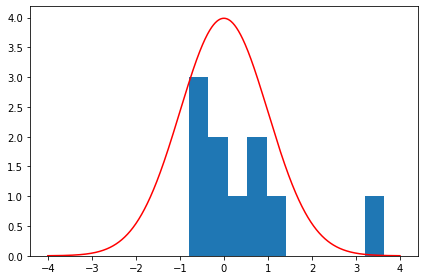

In [48]:
check_sample(10, 0, 1)

Wyniki dla wartości $n=100$, $\mu=0$ i $\sigma=2$:

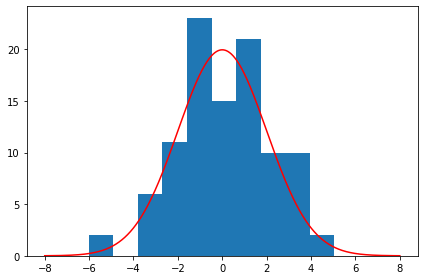

In [49]:
check_sample(100, 0, 2)

Wyniki dla wartości $n=5000$, $\mu=100$ i $\sigma=1.5$:

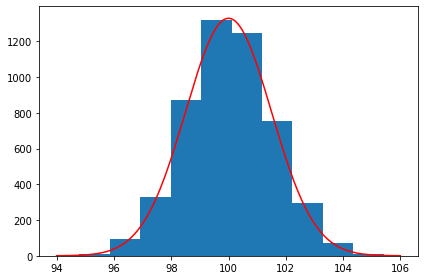

In [56]:
check_sample(5000, 100, 1.5)

Dodatkowo wykonałem test Shapiro-Wilka przy użyciu funkcji znajdującej się w bibliotece `scipy.stats`. Test wykonałem dla ciągu o maksymalnej długości $n=50$ ze względu na fakt, iż dla to była maksymalna wartość w znalezionych w Internecie tabelach do analizy wartości $pValue$ w zależności od wartości $\alpha$.

In [78]:
def shapiro_test():
    xs = np.arange(3, 51, 1)
    ys = []
    
    for n in xs:
        sum = 0
        for i in range(100):
            W, p = stats.shapiro(box_muller(n, 0, 1))
            sum += p
        ys.append(sum / 100)
    
    plt.plot(xs, ys)
    plt.show()

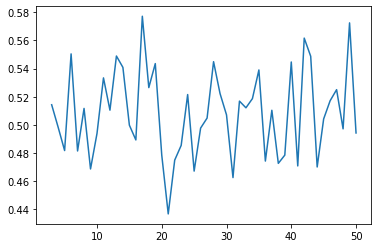

In [79]:
shapiro_test()

Jak widzimy wartości $pValue$ w zależności od długości ciągu $n$ oscyluje pomiędzy wartościami $0.42$ a $0.56$. Na podstawie tabel (dostępna tutaj: http://www.real-statistics.com/statistics-tables/shapiro-wilk-table/) możemy stwierdzić, iż wartości krytyczne dla testowanego przedziału długości ciągów (tj. od $3$ do $50$) oscylują pomiędzy wartościami $0.767$ a $0.947$. Zatem mamy podstawy do odrzucenia hipotezy o normalności rozkładu badanych danych.

### Zadanie 3: Zasada Monte Carlo

Napisz funkcję która zwróci przybliżoną wartość liczby pi wykorzystującą metodę Monte Carlo do obliczenia pola powierzchni koła jednostkowego. Funkcja powinna przyjmować liczbę wylosowanych punktów jako parametr. Zwizualizuj koło, zaznaczając na jednym kolorem punkty które trafiły do jego wnętrza, a drugim te które trafiły na zewnątrz. Na wykresie zwizualizuj błąd bezwzględny wraz z rosnącą liczbą punktów

Przy implementacji funkcji zwracającej przybliżoną wartość liczby pi z wykorzystaniem metody Monte Carlo, wykorzystałem informacje znajdujące się w artykule https://pl.wikipedia.org/wiki/Metoda_Monte_Carlo.

In [435]:
def monte_carlo(n, visualisation=False):
    # generate n random points which belong to unit square:
    points = np.array(list(map(lambda x: (random.uniform(-1, 1), random.uniform(-1,1)), np.zeros(n))))
    
    inner_points = []
    outer_points = []
    
    # check if point belongs to unit circle:
    for (x, y) in points:
        if x ** 2 + y ** 2 <= 1:
            inner_points.append((x, y))
        else:
            outer_points.append((x, y))
    
    # data visualisation:
    if visualisation:      
        xs_in = [x for (x, y) in inner_points]
        ys_in = [y for (x, y) in inner_points]
        
        xs_out = [x for (x, y) in outer_points]
        ys_out = [y for (x, y) in outer_points]
        
        plt.plot(xs_out, ys_out, 'g')
        plt.plot(xs_in, ys_in, 'b')
        plt.show()
    
    return 4 * len(inner_points) / n

Wynik funkcji wraz z wizualizacją dla wartości $n=10000$:

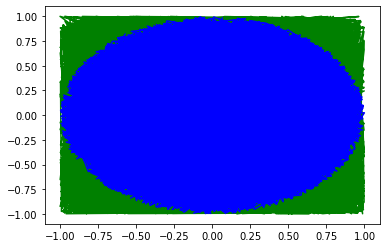

3.1296

In [436]:
monte_carlo(10000, visualisation=True)

Następnie, w celu weryfikacji poprawności otrzymanej wartości liczby pi, stworzyłem funkcję, która wizualizuje błąd bezwzględny w stosunku do rzeczywistej wartości liczby pi w zależności od liczby losowanych punktów $n$:

In [441]:
def monte_carlo_abs_error(max):
    xs = np.arange(1, max + 1, 1)
    ys = list(map(lambda x: abs(np.pi - monte_carlo(x)), xs))
    
    plt.plot(xs, ys)
    plt.show()

Wyniki otrzymane dla maksymalnej ilości losowanych punktów $n=5000$:

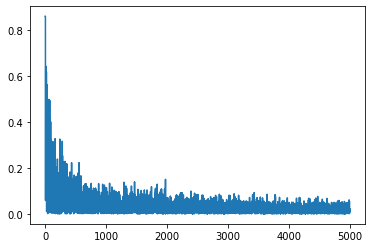

In [444]:
monte_carlo_abs_error(5000)

Jak widać błąd bezwzględny znacząco maleje ju przy wartościach $n$ równych około $100-200$. Dla większych wartości błąd ten utrzymuje się na względnie stałej wartości (która jest i taka mała w porównaniu do samej wartości liczby pi). Zatem można uznać, że metoda ta (tj. metoda Monte Carlo) jest dobrą metodą na wyznaczanie m.in. wartości liczby pi.